In [11]:
import pandas as pd 
import re
import string
import seaborn as sns
import demoji
demoji.download_codes() 
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from matplotlib import style
style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

C:\Users\Acer\AppData\Local\Temp\ipykernel_61840\1294574695.py:6: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


**EDA**

In [12]:
data_2 = pd.read_csv("bbc_news_text_complexity_summarization.csv")
data_2.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...


In [13]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   text                          2127 non-null   object 
 1   labels                        2127 non-null   object 
 2   no_sentences                  2127 non-null   int64  
 3   Flesch Reading Ease Score     2127 non-null   float64
 4   Dale-Chall Readability Score  2127 non-null   float64
 5   text_rank_summary             2127 non-null   object 
 6   lsa_summary                   2127 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 116.4+ KB


In [17]:
data_2.isnull().sum()

text                            0
labels                          0
no_sentences                    0
Flesch Reading Ease Score       0
Dale-Chall Readability Score    0
text_rank_summary               0
lsa_summary                     0
dtype: int64

C:\Users\Acer\AppData\Local\Temp\ipykernel_61840\1500317075.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", edgecolor="black")


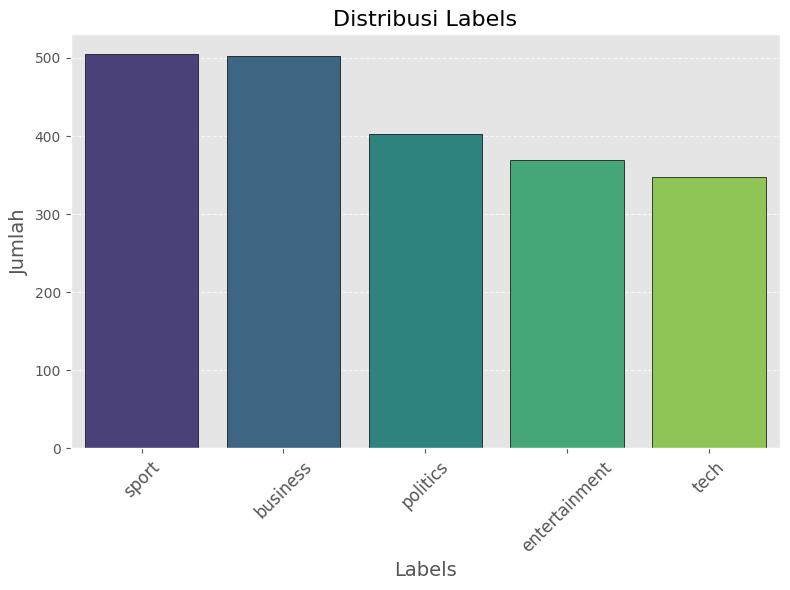

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


label_counts = data_2["labels"].value_counts()


plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", edgecolor="black")
plt.title("Distribusi Labels", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Jumlah", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**PREPROCESSING**

In [32]:
data_2 = data_2.drop(["no_sentences","Flesch Reading Ease Score","Dale-Chall Readability Score" ,"text_rank_summary","lsa_summary"],axis=1)

In [33]:
data_2

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business
...,...,...
2122,New consoles promise big problems\n\nMaking ga...,tech
2123,BT program to beat dialler scams\n\nBT is intr...,tech
2124,Be careful how you code\n\nA new European dire...,tech
2125,US cyber security chief resigns\n\nThe man mak...,tech


In [ ]:
# Ambil kolom teks
data = data_2["text"]
# Konversi teks ke huruf kecil
data = data.str.lower()
# Hapus data duplikat
data = data.drop_duplicates()
# Hapus URL
data = data.str.replace(r'https?://\S+|www\.\S+', '', regex=True)
# Menggunakan BeautifulSoup untuk menghapus tag HTML
def remove_html(text):
    return BeautifulSoup(text, "html.parser").get_text()
data = data.apply(remove_html)
# Inisialisasi data untuk emoji
def replace_emojis_with_text(text):
    return demoji.replace_with_desc(text, sep=":")
data = data.apply(replace_emojis_with_text)
# Hapus mention (@) dan hashtag (#)
def remove_tags_mentions(text):
    return re.sub(r'(@\S+|#\S+)', '', text)
data = data.apply(remove_tags_mentions)
# Hapus tanda baca
PUNCTUATIONS = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))
data = data.apply(remove_punctuation)
# Hapus stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])
data = data.apply(remove_stopwords)
# Hapus angka
data = data.str.replace(r'\d+', '', regex=True)
# Hapus spasi berlebih
def remove_whitespaces(text):
    return " ".join(text.split())
data = data.apply(remove_whitespaces)
# Masukkan teks yang sudah dibersihkan ke dalam dataframe asli
data_2["text"] = data
# Hapus baris yang mengandung nilai kosong
data_2 = data_2.dropna()


In [35]:
data_2

,text,labels
0,ad sales boost time warner profit quarterly pr...,business
1,dollar gains greenspan speech dollar hit highe...,business
2,yukos unit buyer faces loan claim owners embat...,business
3,high fuel prices hit bas profits british airwa...,business
4,pernod takeover talk lifts domecq shares uk dr...,business
...,...,...
2122,new consoles promise big problems making games...,tech
2123,bt program beat dialler scams bt introducing t...,tech
2124,careful code new european directive could put ...,tech
2125,us cyber security chief resigns man making sur...,tech


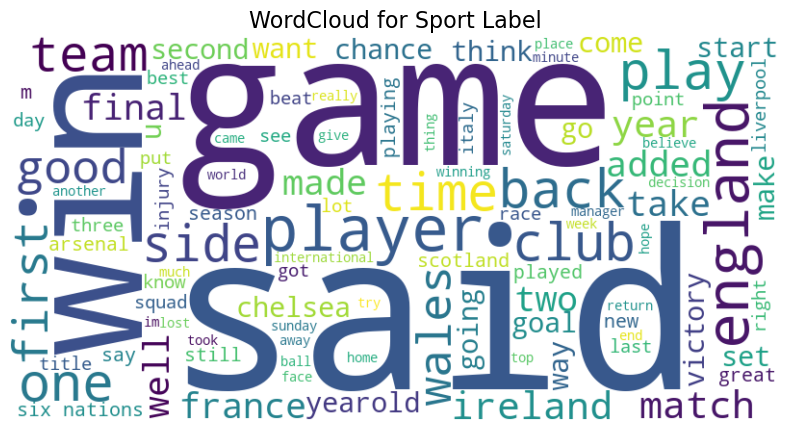

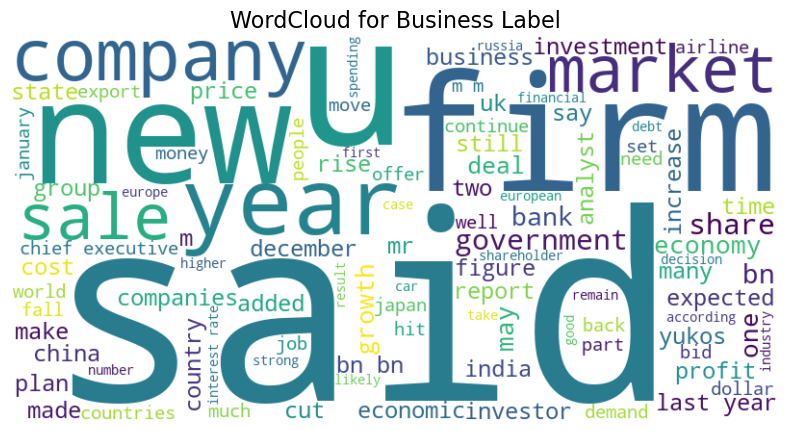

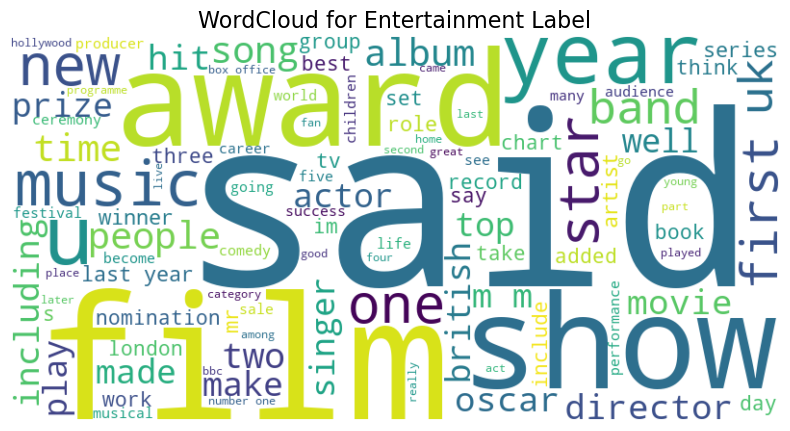

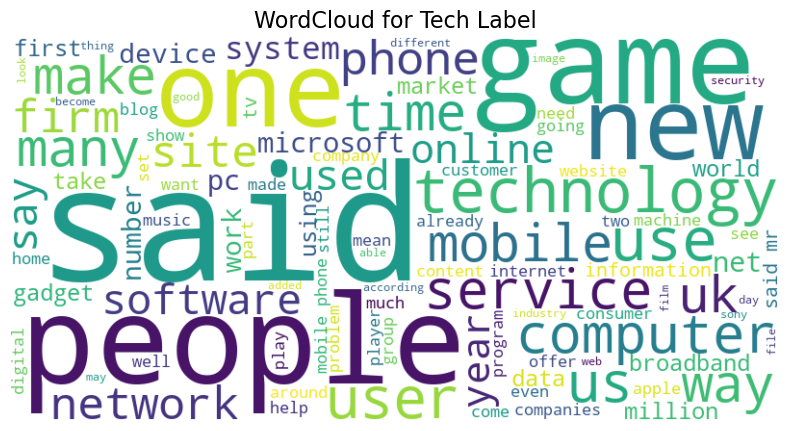

In [36]:
from wordcloud import WordCloud
# Menggabungkan teks dari kolom tertentu

# Daftar label yang ingin divisualisasikan
labels = ['sport', 'business', 'entertainment', 'tech']

# Membuat WordCloud untuk setiap label
for label in labels:
    # Filter data berdasarkan label
    text = " ".join(data_2[data_2['labels'] == label]['text'].dropna())

    # Membuat WordCloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        colormap='viridis', 
        max_words=100
    ).generate(text)

    # Menampilkan WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Menghilangkan axis
    plt.title(f"WordCloud for {label.capitalize()} Label", fontsize=16)
    plt.show()

**DATA SPLITTING AND FEATURE EXTRACTION**

In [37]:
tfidf_model = TfidfVectorizer(ngram_range=(0, 3))

vect2 = tfidf_model.fit(data_2['text'])

x = data_2['text']
Y = data_2['labels']
X = vect2.transform(x)

# Membagi dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

# Menampilkan bentuk (shape) dari data
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Menampilkan jumlah setiap kelas pada data y_test
class_counts = pd.Series(y_test).value_counts()
print("\nJumlah setiap kelas pada data test:")
print(class_counts)


Shape of x_train: (1700, 779840)
Shape of x_test: (426, 779840)
Shape of y_train: (1700,)
Shape of y_test: (426,)

Jumlah setiap kelas pada data test:
labels
sport            104
business          93
politics          86
tech              72
entertainment     71
Name: count, dtype: int64


**TRAIN MODEL**

               precision    recall  f1-score   support

     business       0.96      0.98      0.97        93
entertainment       0.97      0.99      0.98        71
     politics       0.98      0.93      0.95        86
        sport       0.99      1.00      1.00       104
         tech       0.99      0.99      0.99        72

     accuracy                           0.98       426
    macro avg       0.98      0.98      0.98       426
 weighted avg       0.98      0.98      0.98       426

Test accuracy: 97.65%


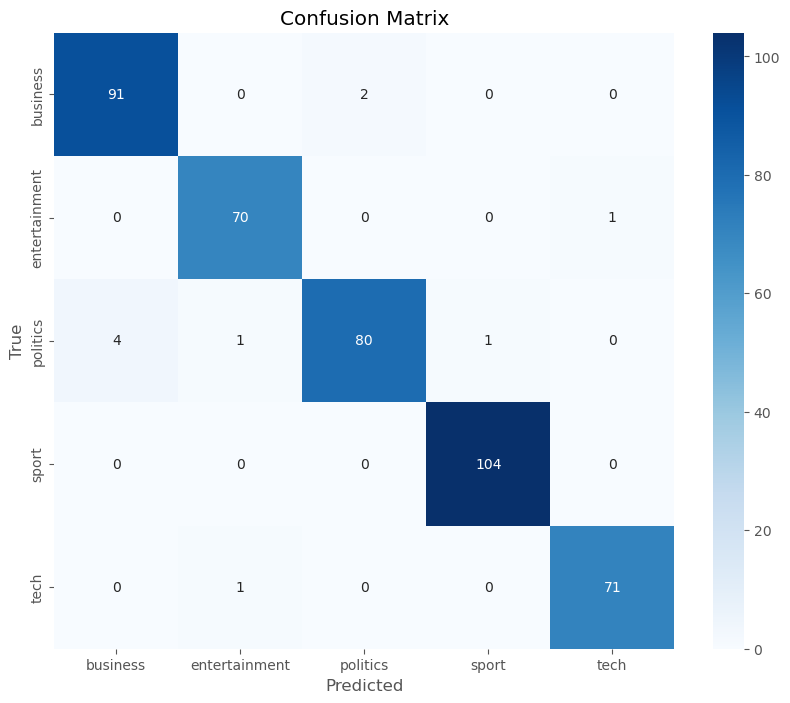

In [38]:
# Inisialisasi model SVM
svm_model = SVC(C=100, kernel='linear', class_weight='balanced', random_state=123)
svm_model.fit(x_train, y_train)

# Prediksi menggunakan model SVM
svm_predict = svm_model.predict(x_test)

# Hitung akurasi
svm_acc = accuracy_score(svm_predict, y_test)
print(classification_report(y_test, svm_predict))
print("Test accuracy: {:.2f}%".format(svm_acc * 100))

# Matriks kebingungan (Confusion Matrix)
cm = confusion_matrix(y_test, svm_predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
